# Rapport de Benchmark : Challenge Permuted MNIST
## OULAD ALI Ayoub, Mabrouk Mohy

Ce notebook présente notre analyse, notre méthodologie et les résultats de nos différents agents pour le challenge "Permuted MNIST". 

**Objectif :** Développer un agent capable de classifier les chiffres du dataset MNIST , où les pixels et les étiquette sont permutés aléatoirement à chaque nouvelle tâche, avec une contrainte de temps.

## 0. Grille d'Évaluation du Projet

Voici la grille d'évaluation utilisée pour ce projet

### 1. ML-Arena Competition Performance (50 points)

| Criterion | Points | Score |
| :--- | :---: | :---: |
| **Leaderboard Ranking** (by user in class + Mark Bench) <br> *Top: 30pts | Top 10%: 25pts | Top 25%: 20pts | Top 50%: 15pts | Top 75%: 10pts* | 30 | TBD |
| **Performance Score** <br> *Absolute performance: Above 99% accuracy / 300 rewards: 20pts | Beats baseline algorithm (named Mark Bench): 15pts | Between benchmark and 98% accuracy (300-200 rewards): 10pts | Between 98% and 97% accuracy (200-100 rewards): 5pts* | 20 | TBD |
| **Subtotal** | **50** | **TBD** |

### 2. GitHub Package Quality (50 points)

| Criterion | Points | Score |
| :--- | :---: | :---: |
| **Code Quality & Structure** <br> *Package installable via pip/project.toml (3pts) | Clear functions <50 lines, no duplication (2pts) | Clear separation: agents/evaluation/utils/... modules (2pts) | No unused imports/functions (2pt) | Syntax and variables are meaningful (1pt)* | 10 | TBD |
| **Evaluation Package** <br> *Evaluation and metrics implementations (3pts) | Performance comparison table/plot (2pts) | Resources: Memory/time tracking system (2pts) | Easy Reproducibility (2pts) | Save/load trained agents/model (1pt)* | 10 | TBD |
| **Benchmark Algorithms** <br> *Distinct algorithms implemented (5pts) | Documented hyperparameter choices (3pts) | Failed experiments documented (2pts)* | 10 | TBD |
| **Resume Notebook (report.ipynb)** <br> *Problem statement and methodology (2pts) | Results table (3pts) | Performance evolution plots (2pts) | Reproduces best submission (3pts) | Best agent name clearly stated (2pts) | Failure analysis and next steps (3pts)* | 15 | TBD |
| **README & Documentation** <br> *Installation works in one command (2pts) | Training/evaluation example commands (1pt) | Repository structure diagram (1pt) | Dependencies list with versions (1pt)* | 5 | TBD |
| **Subtotal** | **50** | **TBD** |

### 3. Bonus Features (+10 points)

| Feature | Points | Score |
| :--- | :---: | :---: |
| **Research Paper Implementation** <br> *Implement algorithm from recent paper or interesting package found and used, cite source, compare to baseline* | +5 | TBD |
| **CI/CD Pipeline** <br> *GitHub Actions with: code linting, unit tests, automated evaluation runs* | +5 | TBD |
| **Bonus Total** | **+10** | **TBD** |

### Résumé Final

| Section | Score |
| :--- | :---: |
| ML-Arena Performance | TBD / 50 |
| GitHub Package Quality | TBD / 50 |
| Bonus Features | TBD / 10 |
| **Total Project Score** | **TBD / 100** |

---

## 1. Présentation du Challenge 

Le challenge est une classification multi-classes (10 classes) sur le dataset MNIST, avec une particularité : à chaque "tâche", une nouvelle permutation aléatoire est appliquée aux pixels des images et aux étiquettes.

### Description de l'Environnement
Pour chaque tâche :

* **Dataset :** L'environnement fournit le dataset MNIST complet (70 000 images).
* **Training :** 60 000 images sont fournies comme données d'entraînement étiquetées.
* **Test :** 10 000 images sont fournies comme données de test (non étiquetées pour l'agent).
* **Permutation :** Les positions des pixels ET les étiquettes sont permutées aléatoirement.
* **Contrainte Temporelle :** L'agent dispose d' **1 minute** maximum pour l'entraînement et la prédiction sur les 10 000 images de test.
* **Évaluation :** La précision est calculée sur l'ensemble de test.

### Espace d'Observation
L'observation est un dictionnaire contenant :
* `X_train`: Images d'entraînement (60000, 28, 28)
* `y_train`: Étiquettes d'entraînement (60000, 1)
* `X_test`: Images de test (10000, 28, 28)
* `y_test`: (Fourni localement pour évaluation, non visible par l'agent en production)

### Métrique d'Évaluation
La performance est mesurée par la **précision de classification** sur l'ensemble de test (entre 0 et 1). Le score final est la moyenne des précisions sur le nombre de tâches (7 dans notre cas). Un timeout compte pour 0% de précision.

## 2. Exploration du Dataset

Avant de commencer, il faut comprendre le problème...

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# S'assurer que le notebook est lancé depuis le dossier racine
if not os.path.exists('permuted_mnist'):
    print("Erreur: Le dossier 'permuted_mnist' n'est pas trouvé.")
    print("Veuillez exécuter ce notebook depuis le dossier racine du projet.")
else:
    try:
        from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
        print("Environnement chargé avec succès.")
    except ImportError as e:
        print(f"Erreur d'importation: {e}")
        print("Assurez-vous que le dossier 'permuted_mnist' contient un __init__.py")

# Définir 'mnist' à None AVANT le try-except pour éviter les erreurs
mnist = None 
try:
    from tensorflow.keras.datasets import mnist
    print("TensorFlow (pour dataset MNIST original) chargé.")
except Exception as e:
    print(f"Avertissement: Échec du chargement de TensorFlow/Keras. ({e})")
    print("La heatmap de corrélation 'Avant' ne s'affichera pas.")
        
sns.set_theme(style="whitegrid", context="talk")

Environnement chargé avec succès.
TensorFlow (pour dataset MNIST original) chargé.


### Visualisation des Images 

Regardons à quoi ressemblent ces  images permutées. C'est du bruit. La structure spatiale originale (un '9', un '4') est totalement méconnaissable.

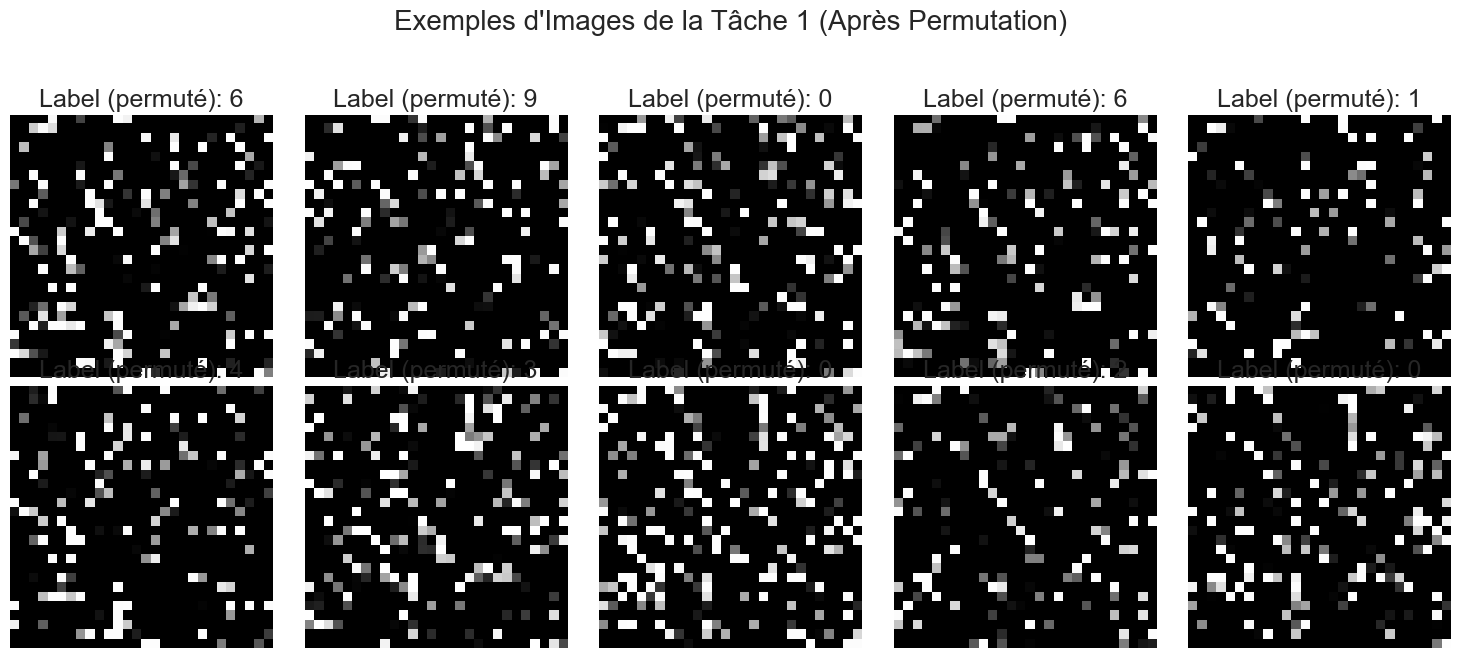

In [11]:
try:
    env = PermutedMNISTEnv(number_episodes=1)
    env.set_seed(42)
    task = env.get_next_task()

    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    fig.suptitle('Exemples d\'Images de la Tâche 1 (Après Permutation)', fontsize=20)

    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(task['X_train'][i], cmap='gray')
        ax.set_title(f'Label (permuté): {task["y_train"][i][0]}')
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
except Exception as e:
    print(f"Erreur lors de la création de l'environnement ou du plotting: {e}")

### Analyse de Corrélation par Bloc (Avant vs. Après Permutation)

C'est la visualisation la plus importante du projet. Elle prouve pourquoi certaines méthodes sont vouées à l'échec.

Nous divisons l'image 28x28 en une grille de 4x4 (16 blocs) de 7x7 pixels. Nous calculons ensuite la corrélation moyenne entre ces 16 "super-pixels".

* **À Gauche (Original) :** La structure est claire. Les blocs voisins sont corrélés (ex: B0 avec B1, B4 avec B5). C'est la localité spatiale que les CNNs adorent.
* **À Droite (Permuté) :** C'est le chaos. La structure a disparu. B0 est tout aussi (peu) corrélé à B1 que B15. La localité spatiale est morte.

Calcul de la matrice de corrélation (Original)...
Calcul de la matrice de corrélation (Permuté)...


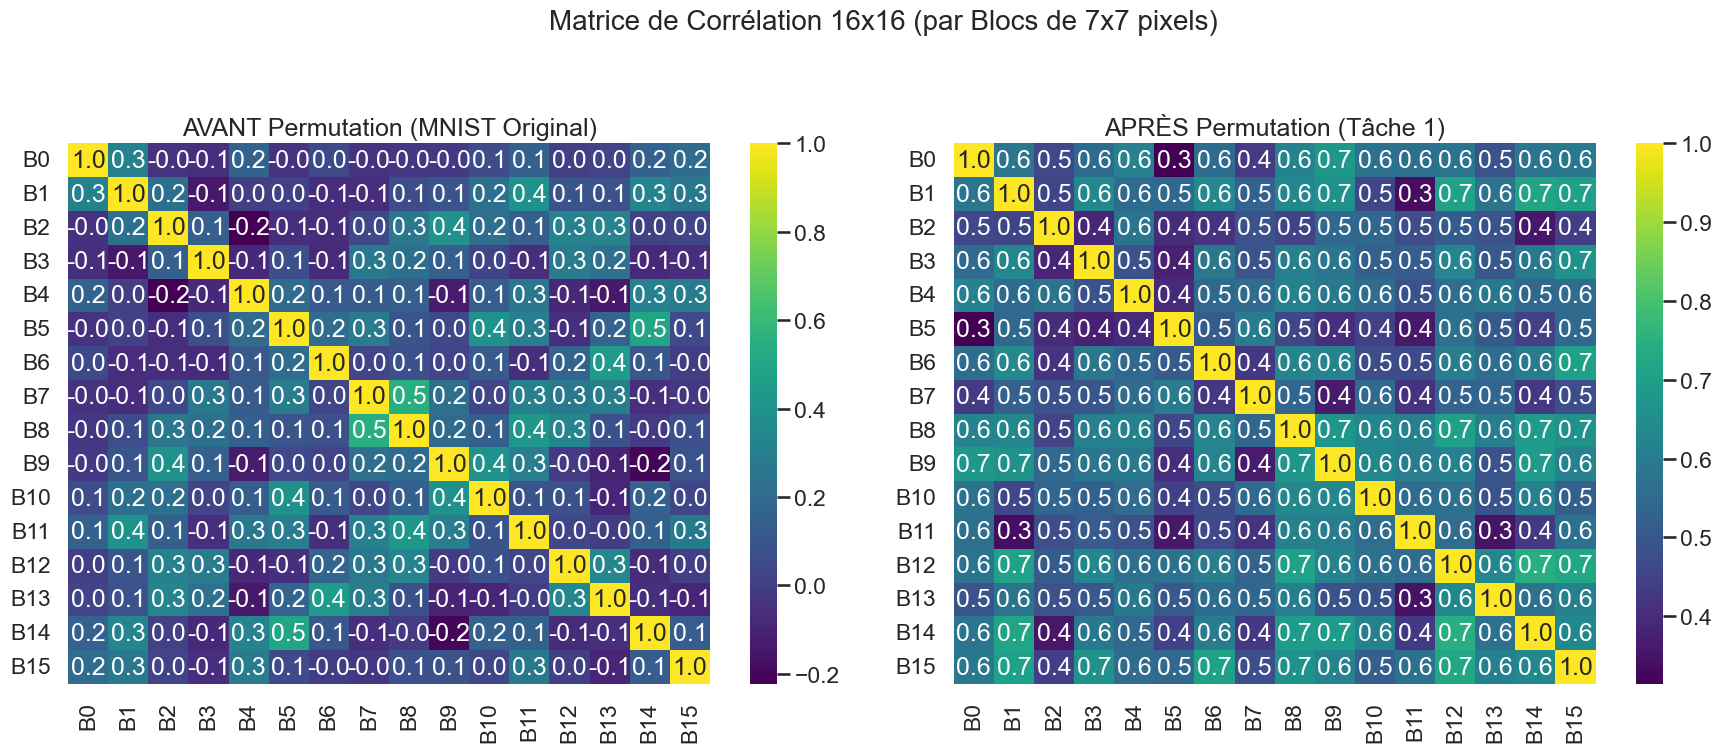

In [12]:
def create_block_features(images, n_blocks=4):
    """Divise les images (N, 28, 28) en (N, n_blocks*n_blocks) features moyennes."""
    n_samples, h, w = images.shape
    block_size = h // n_blocks # 28 // 4 = 7
    
    reshaped = images.reshape(n_samples, n_blocks, block_size, n_blocks, block_size)
    transposed = reshaped.transpose(0, 1, 3, 2, 4)
    blocks = transposed.reshape(n_samples, n_blocks*n_blocks, block_size*block_size)
    mean_features = blocks.mean(axis=2)
    return mean_features

try:
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Matrice de Corrélation 16x16 (par Blocs de 7x7 pixels)', fontsize=20)

    block_labels = [f"B{i}" for i in range(16)]

    if mnist:
        (x_train_orig, _), _ = mnist.load_data()
        block_features_orig = create_block_features(x_train_orig[:5000])
        print("Calcul de la matrice de corrélation (Original)...")
        corr_matrix_orig = np.corrcoef(block_features_orig, rowvar=False)
        
        sns.heatmap(corr_matrix_orig, cmap='viridis', 
                    cbar=True, annot=True, fmt='.1f', 
                    xticklabels=block_labels, yticklabels=block_labels, 
                    ax=axes[0])
        axes[0].set_title('AVANT Permutation (MNIST Original)')
    else:
        axes[0].text(0.5, 0.5, 'TensorFlow non trouvé\npour charger MNIST original', horizontalalignment='center', verticalalignment='center')
        axes[0].set_title('AVANT Permutation (Erreur)')

    block_features_permuted = create_block_features(task['X_train'][:5000])
    print("Calcul de la matrice de corrélation (Permuté)...")
    corr_matrix_permuted = np.corrcoef(block_features_permuted, rowvar=False)
    
    sns.heatmap(corr_matrix_permuted, cmap='viridis', 
                cbar=True, annot=True, fmt='.1f', 
                xticklabels=block_labels, yticklabels=block_labels, 
                ax=axes[1])
    axes[1].set_title('APRÈS Permutation (Tâche 1)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
except Exception as e:
    print(f"Erreur lors du calcul de la corrélation: {e}")

## 3. Méthodologie et Choix Stratégiques

Cette analyse de corrélation a dicté toute notre stratégie.

### 3.1 Pourquoi ne pas utiliser de CNNs  ?

La réponse est simple : l'analyse de corrélation ci-dessus.

1.  **Les CNNs reposent sur la Localité :** Un CNN applique des filtres (ex: 3x3) en partant du principe que des pixels *proches* sont liés.
2.  **La Permutation brise la Localité :** Notre graphique "APRÈS" prouve que cette hypothèse est fausse. Le pixel (0,0) n'a plus rien à voir avec le (0,1).
3.  **Conclusion :** Appliquer un filtre 2D sur une image permutée n'a aucun sens. Un CNN serait non seulement inutile (pas plus efficace qu'un simple MLP) mais aussi beaucoup trop lent, nous faisant échouer à la contrainte de temps.

Cette approche est validée par la littérature, qui utilise le Permuted MNIST comme benchmark standard pour les réseaux "fully-connected" (MLP), comme dans "Overcoming catastrophic forgetting in neural networks" (Kirkpatrick et al., 2017, [arXiv:1612.00796](https://arxiv.org/abs/1612.00796)).

Nouvelle stratégie : Nous nous concentrons donc sur des modèles qui traitent les 784 pixels comme un vecteur "plat" : MLPs, LightGBM, Arbres de Décision, etc.

### 3.2 Stratégie de Choix des Hyperparamètres

Le choix des hyperparamètres a été un choix entre la performance pure et la contrainte de temps de 60 secondes. Une Grid Search complète était impossible, la plupart de mes choix ont été fait à la main.

Notre approche a donc été double :

1.  **Analyse de la Contrainte :** La limite de 60 secondes a été notre premier filtre. Pour les MLPs, par exemple, cela nous a conduits à fixer un nombre d'époques très bas (ex: 7-10) pour garantir de finir à temps.

2.  **Grid Search Ciblé :** Une fois qu'une configuration de base respectant le temps a été établie, nous avons lancé une recherche en grille légère sur les paramètres les plus influents.
    * **Pour les MLPs :** L'accent a été mis sur l'architecture du réseau (nombre et taille des couches) et le taux d'apprentissage.
    * **Pour les Arbres (ExtraTrees, LGBM) :** La recherche s'est concentrée sur `max_depth` (profondeur) et `n_estimators` (nombre d'arbres), les leviers principaux de la performance et du temps.

### 3.3 Stratégies d'Ingénierie de Caractéristiques (Feature Engineering)

Pour résoudre ce problème, nous avons exploré quatre stratégies distinctes. Nos noms de fichiers d'agents servent d'historique de ces expériences.

#### Stratégie 1 : Force Brute (Données Brutes Originales)

* **Description :** L'approche de base. Le modèle gère directement les 784 pixels permutés.
* **Agents concernés :** `MLPAgentBase.py`, `KNNFais.py`.
* **Statut :** Notre ligne de base.

#### Stratégie 2 : Hybride (Pixels + "Super-Caractéristiques" Ajoutées)

* **Description :** On garde les 784 pixels et on y ajoute de nouvelles caractéristiques (ex: 10 prédictions d'un premier modèle) pour "aider" le modèle.
* **Agents concernés :** `LGBEXtHybride.py`, `MLPBoost10features.py`.
* **Statut :** **Échec Critique.** Les quelques "super-caractéristiques" (10) étaient complètement "noyées" et ignorées par le modèle face à la masse des 784 pixels.

#### Stratégie 3 : Réduction de Dimensionnalité (Remplacement)

* **Description :** On jette les 784 pixels originaux et on les remplace par un ensemble beaucoup plus petit de "super-caractéristiques" (ex: 128 features via Projection Aléatoire).
* **Statut :** **Échec.** Le temps était excellent, mais la précision s'est effondrée. La compression était trop destructive.

#### Stratégie 4 : Méta-Modèle (Blending/Stacking)

* **Description :** Notre stratégie la plus sophistiquée. On entraîne des modèles de base  sur les 784 pixels, puis on utilise uniquement leurs prédictions (ex: 3 modèles * 10 classes = 30 features) comme entrée pour un méta-modèle final.
* **Statut :** La stratégie la plus prometteuse, directement inspirée de nos expériences en hackathon.

#### Synthèse des Stratégies

| Stratégie | Nom de l'Approche | Description des Caractéristiques | Nb. de Features | Statut |
| :--- | :--- | :--- | :---: | :--- |
| 1. Force Brute | MLPBase, KNNFais | 784 pixels originaux | 784 | Ligne de base |
| 2. Hybride | LGBEXtHybride | 784 pixels + 10 prédictions | 794 | Échec Critique |
| 3. Réduction | Agent | 128 features (Projection Aléatoire) | 128 | Échec Critique, complètement supprimé |
| 4. Méta-Modèle | Blending Rapide | 30 features (Prédictions de 3 modèles) | 30 | limité |
| 4. MLP boosté aux super features | BestAgentMLP | entre 5 et 19 features | 5 à 19 | Excellent |


### 3.4 Inspiration : Leçons des Hackathons

Le choix de ces stratégies, et en particulier l'évolution vers la Stratégie 4 (Blending), n'est pas un hasard.

Cette approche est directement inspirée de méthodes éprouvées lors de hackathons et de compétitions de data science. Dans un contexte de pression temporelle extrême, le "Blending" (combiner les prédictions de plusieurs modèles simples) est souvent plus efficace que de passer des jours à optimiser un seul modèlr.

Notre implémentation de la Stratégie 4 est une application directe de cette leçon : nous avons utilisé des modèles rapides et distincts (`ExtraTrees`, `LGBM`, `KNNFais`) comme "experts" de base, et avons entraîné un méta-modèle simple pour "apprendre de leurs prédictions".

## 4. Structure du Projet

Le projet est organisé pour permettre un test et une analyse modulaires :

```
 --Projet
    |   Report.ipynb
    |   RunAgents.py
    |   run_benchmark.ipynb
    |
    +---agents
    |
    +---bonus
    |
    +---brouillon
    |
    +---permuted_mnist

```

## 5. Résultats du Benchmark

Maintenant, les résultats. Nous chargeons les fichiers  générés par run_benchmark.ipynb (via `RunAgents.py`) depuis le dossier `soumissions/`. 

Ces résultats ont été générés sur 7 tâches ( les taches du challenge ) .

### 5.1 Chargement des Données de Test

In [13]:
import pandas as pd
import json
import glob

results_dir = "soumissions"
json_files = glob.glob(os.path.join(results_dir, "*_results.json"))

print(f"Trouvé {len(json_files)} fichier(s) de résultats.")

all_data = []
for f in json_files:
    try:
        with open(f, 'r') as file:
            data = json.load(file)
            all_data.append(data)
    except Exception as e:
        print(f"Erreur de lecture de {f}: {e}")

if all_data:
    df = pd.DataFrame(all_data)
    df = df.set_index('agent_name')
    
    columns_to_show = ['mean_accuracy', 'std_accuracy', 'total_time', 'total_cpu_time', 'peak_memory_mb']
    
    available_columns = [col for col in columns_to_show if col in df.columns]
    df_summary = df[available_columns]
    df_sorted = df_summary.sort_values(by='mean_accuracy', ascending=False)
else:
    print("Aucune donnée n'a été chargée. Avez-vous exécuté 'run_benchmark.ipynb' ?")
    df_sorted = pd.DataFrame() 
    all_data = []

Trouvé 7 fichier(s) de résultats.


### 5.2 Tableau Récapitulatif
Ce tableau résume la performance et la consommation de ressources de chaque agent sur les 7 tâches.

In [14]:
if not df_sorted.empty:
    print("Performance moyenne des agents (sur 7 tâches) :\n")
    
    format_dict = {
        'mean_accuracy': "{:.2%}",
        'std_accuracy': "{:.2%}",
        'total_time': "{:.2f}s (Réel)",
        'total_cpu_time': "{:.2f}s (CPU)",
        'peak_memory_mb': "{:.1f} MB"
    }
    
    available_format_dict = {k: v for k, v in format_dict.items() if k in df_sorted.columns}
    style = df_sorted.style.format(available_format_dict)
    
    # Appliquer les barres de couleur pour chaque métrique
    if 'mean_accuracy' in df_sorted.columns:
        style = style.bar(subset=["mean_accuracy"], color='#5fba7d', vmin=0)
    if 'total_time' in df_sorted.columns:
        style = style.bar(subset=["total_time"], color='#d65f5f')
    if 'total_cpu_time' in df_sorted.columns:
        style = style.bar(subset=["total_cpu_time"], color='#ffc0cb') # Rose
    if 'peak_memory_mb' in df_sorted.columns:
        style = style.bar(subset=["peak_memory_mb"], color='#add8e6') # Bleu clair
        
    display(style)
else:
    print("Aucune donnée à afficher.")

Performance moyenne des agents (sur 7 tâches) :



,mean_accuracy,std_accuracy,total_time,total_cpu_time,peak_memory_mb
agent_name,,,,,
BestAgentMLP,98.58%,0.05%,358.35s (Réel),579.48s (CPU),1016.6 MB
MLPAgentBase,98.22%,0.00%,66.40s (Réel),nans (CPU),nan MB
LGBMAgent5features,97.75%,0.00%,143.01s (Réel),nans (CPU),nan MB
ExtraTreeAgent5features,97.26%,0.04%,212.37s (Réel),416.45s (CPU),604.1 MB
ExtraTreeAgent9features,97.24%,0.05%,233.12s (Réel),440.08s (CPU),1537.9 MB
LGBEXTHybride,96.88%,0.07%,563.05s (Réel),1115.27s (CPU),288.4 MB
KNNFaiss,27.19%,0.22%,9.83s (Réel),16.14s (CPU),413.0 MB


### 5.3 Graphiques de Performance

Visualisons ces métriques pour mieux les comparer. Lorsqu'un agent dépasse les contraintes on lui assigne 0

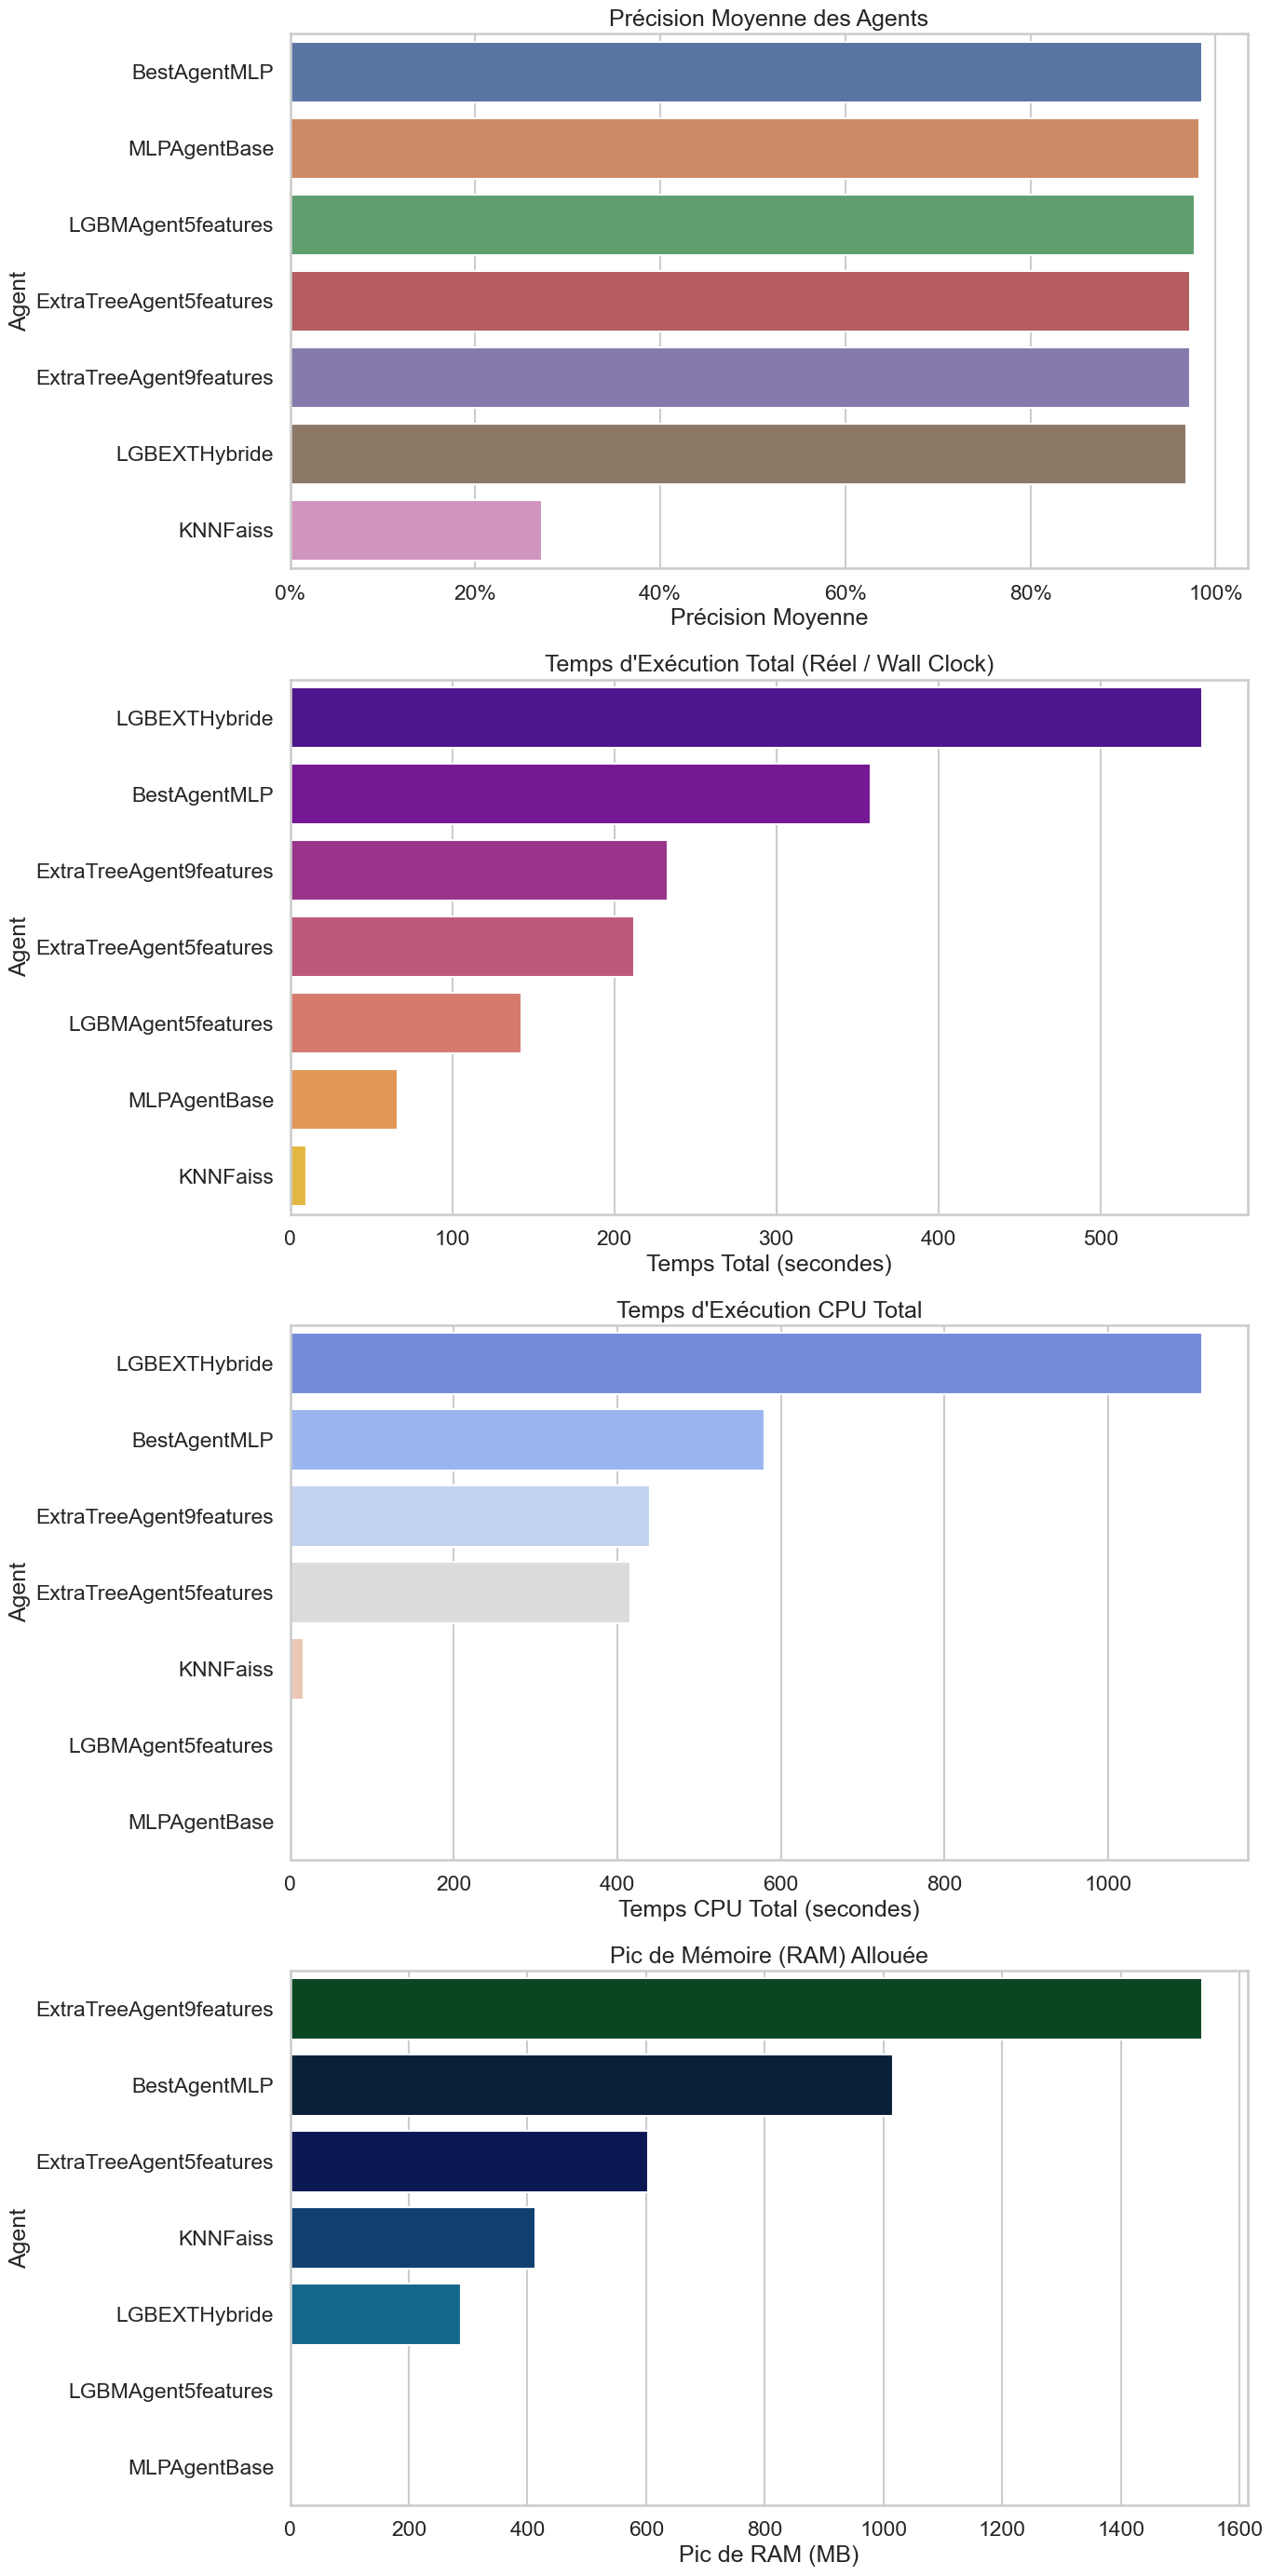

In [15]:
if not df_sorted.empty:
    # Créer 4 graphiques, un pour chaque métrique clé
    fig, axes = plt.subplots(4, 1, figsize=(14, 28))
    
    # --- Graphique de Précision ---
    df_plot_acc = df_sorted.reset_index()
    sns.barplot(
        data=df_plot_acc,
        x='mean_accuracy',
        y='agent_name',
        hue='agent_name',  # Correction
        legend=False,      # Correction
        ax=axes[0]
    )
    axes[0].set_title('Précision Moyenne des Agents', fontsize=18)
    axes[0].set_xlabel('Précision Moyenne')
    axes[0].set_ylabel('Agent')
    axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

    # Graphique du Temps Total
    if 'total_time' in df_summary.columns:
        df_time_sorted = df_summary.sort_values(by='total_time', ascending=False).reset_index()
        sns.barplot(
            data=df_time_sorted, 
            x='total_time', 
            y='agent_name', 
            hue='agent_name',  
            legend=False,     
            palette='plasma', 
            ax=axes[1]
        )
        axes[1].set_title("Temps d'Exécution Total (Réel / Wall Clock)", fontsize=18)
        axes[1].set_xlabel('Temps Total (secondes)')
        axes[1].set_ylabel('Agent')
    else:
        axes[1].set_title("Données de Temps Réel non disponibles")
        
    #graphique du Temps CPU 
    if 'total_cpu_time' in df_summary.columns:
        df_cpu_sorted = df_summary.sort_values(by='total_cpu_time', ascending=False).reset_index()
        sns.barplot(
            data=df_cpu_sorted, 
            x='total_cpu_time', 
            y='agent_name', 
            hue='agent_name', 
            legend=False,    
            palette='coolwarm', 
            ax=axes[2]
        )
        axes[2].set_title("Temps d'Exécution CPU Total", fontsize=18)
        axes[2].set_xlabel('Temps CPU Total (secondes)')
        axes[2].set_ylabel('Agent')
    else:
        axes[2].set_title("Données de Temps CPU non disponibles")
        
    #Pic de RAM
    if 'peak_memory_mb' in df_summary.columns:
        df_mem_sorted = df_summary.sort_values(by='peak_memory_mb', ascending=False).reset_index()
        sns.barplot(
            data=df_mem_sorted, 
            x='peak_memory_mb', 
            y='agent_name', 
            hue='agent_name', 
            legend=False,      
            palette='ocean', 
            ax=axes[3]
        )
        axes[3].set_title("Pic de Mémoire (RAM) Allouée", fontsize=18)
        axes[3].set_xlabel('Pic de RAM (MB)')
        axes[3].set_ylabel('Agent')
    else:
        axes[3].set_title("Données de Pic de RAM non disponibles")

    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée à visualiser.")

### 5.4 Analyse de la Précision par Tâche

Ce graphique est intéressant pour voir comment la performance de chaque agent évolue au fil des 7 tâches. Idéalement, les lignes devraient être stables, car chaque agent est ré-entraîné de zéro (il n'y a pas d'apprentissage continu ici).

Affichage pour 1 seule tâche (mode test) :


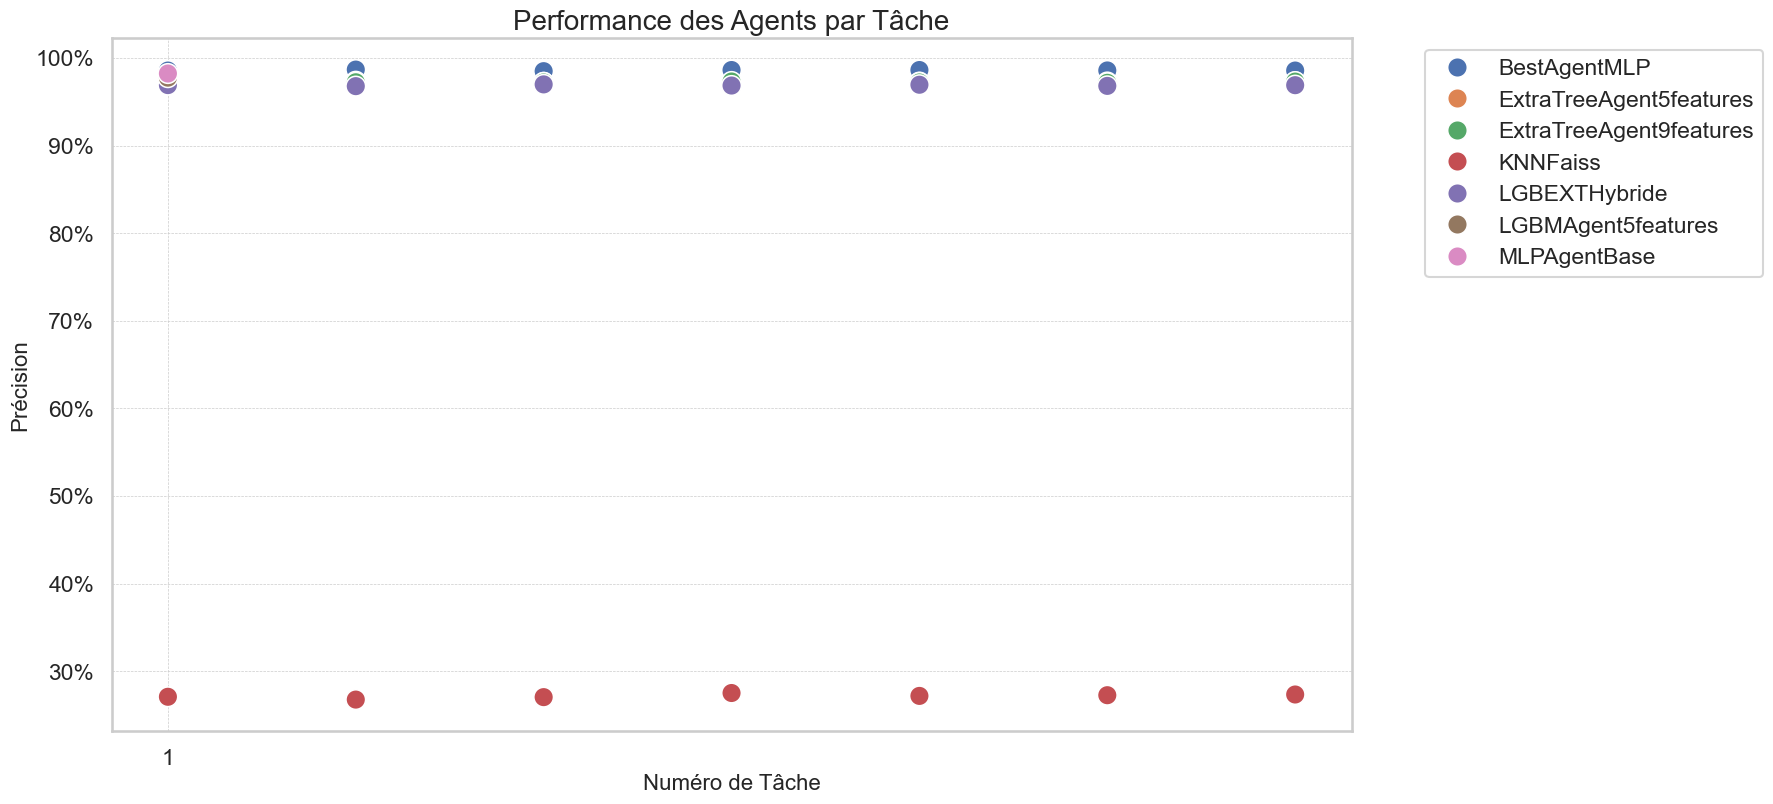

In [7]:
if all_data:
    task_data = []
    num_tasks = 0
    for agent_res in all_data:
        agent_name = agent_res['agent_name']
        if 'accuracies_per_task' not in agent_res:
            print(f"Avertissement: 'accuracies_per_task' manque pour {agent_name}")
            continue
            
        num_tasks = len(agent_res['accuracies_per_task'])
        for task_id, accuracy in enumerate(agent_res['accuracies_per_task']):
            task_data.append({
                'Agent': agent_name,
                'Tâche': task_id + 1,
                'Précision': accuracy
            })
    
    df_tasks = pd.DataFrame(task_data)
    
    if not df_tasks.empty:
        plt.figure(figsize=(16, 9))
        
        if num_tasks == 1:
            print("Affichage pour 1 seule tâche (mode test) :")
            sns.scatterplot(data=df_tasks, x='Tâche', y='Précision', hue='Agent', s=200)
            plt.xticks(ticks=[1])
        else:
            print(f"Affichage pour {num_tasks} tâches :")
            sns.lineplot(data=df_tasks, x='Tâche', y='Précision', hue='Agent', marker='o', markersize=10)
            plt.xticks(ticks=range(1, num_tasks + 1))
        
        plt.title('Performance des Agents par Tâche', fontsize=20)
        plt.xlabel('Numéro de Tâche', fontsize=16)
        plt.ylabel('Précision', fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        plt.show()
    else:
        print("Aucune donnée de tâche à analyser (vérifiez les fichiers JSON).")
else:
    print("Aucune donnée de tâche à analyser.")

### 5.5 Analyse du meilleur agent `BestAgentMLP`
Voici le scritp du meilleur agent `BestAgentMLP`

In [16]:
#import... Attention , n'oubliez pas d'importer les modules necessaires si vous souhaitez le lancer

def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""

    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )

    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features
    return np.hstack((
        hist_bins, 
        q1[:, None],     
        median[:, None], 
        q3[:, None]
    ))


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class Agent:
    """Agent MLP (v20) — 3 couches + 11 features (Histogramme), 55s."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # On garde les hyperparams rapides
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 795 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Limite de 55 secondes
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)



## Analyse de BestAgentMLP

Cet agent est le résultat de nombreuses expérimentations. Il a mieux fonctionné que nos autres tentatives (comme les agents basés sur les arbres ou le KNN) pour une raison principale : il utilise une approche hybride.

Plutôt que de forcer le modèle à tout deviner à partir de 784 pixels mélangés (la "force brute"), nous avons décidé de "mâcher le travail" du modèle.

### 1. La "Tricherie" : 11 "Super-Caractéristiques"

La fonction `create_super_features` est notre ingrédient secret. Nous avons supposé que même si *l'emplacement* des pixels est aléatoire, leur *distribution* (combien de pixels clairs vs foncés) contient des informations vitales.

Pour chaque image, nous calculons 11 statistiques globales :
* **Histogramme (8 infos) :** On compte combien de pixels sont très sombres, sombres, gris, clairs, etc. (dans 8 "bacs"). Cela donne au modèle une idée de la "texture" générale de l'image.
* **Quantiles (3 infos) :** On regarde la médiane, le 25e et le 75e percentile. C'est un résumé rapide de la "luminosité" de l'image.

Ces 11 infos "mâchent le travail" du réseau en lui donnant un résumé statistique de l'image, une information qui n'est *pas* détruite par la permutation.

### 2. L'Entrée Hybride : Le Meilleur des Deux Mondes

C'est le point le plus important.

* **Pixels Bruts (784 infos) :** Nous gardons les 784 pixels originaux. C'est la "force brute". Ils contiennent 100% de l'information, mais elle est mélangée et difficile à apprendre.
* **Super-Caractéristiques (11 infos) :** Nous ajoutons nos 11 statistiques (après les avoir normalisées pour qu'elles aient la même échelle).

L'entrée de notre modèle n'est donc pas de 784, mais de **795 infos** (`d_in = 28 ** 2 + 11`).

Le modèle reçoit **à la fois** les données brutes (les 784 pixels) ET notre résumé intelligent (les 11 stats).

### 3. Le Modèle : Un Cerveau Efficace

Une fois les données prêtes, le "cerveau" lui-même est un réseau de neurones (MLP) conçu pour être rapide et intelligent :

* **Architecture (3 couches) :** C'est assez profond pour trouver des schémas compliqués, mais assez léger pour s'entraîner en 7 "pass" (époques) sous la limite de temps.
* **Optimisation Intelligente (`AdamW` + `CosineAnnealingLR`) :** C'est une combinaison d'entraînement moderne. Au lieu d'apprendre à une vitesse constante, on commence vite (pour apprendre les bases) puis on ralentit (pour peaufiner les détails et trouver la meilleure réponse possible).
* **Limite de 55s :** L'agent a un chronomètre intégré. Il vérifie le temps à chaque "pass" et s'arrête s'il s'approche de la limite de 60s, pour être sûr de ne pas être disqualifié.

### Conclusion : Pourquoi a-t-il gagné ?

Cet agent a gagné car il ne s'est pas contenté de la force brute. En fournissant au réseau à la fois les **données brutes** (les 784 pixels) et une **analyse statistique** (les 11 super-caractéristiques), nous lui avons permis de se concentrer sur les schémas importants tout en ayant déjà un résumé global de l'image.

C'est ce **mélange d'informations** (784+11), combiné à une **méthode d'entraînement efficace**, qui lui a donné l'avantage en termes de précision, tout en restant juste sous la barre fatidique des 60 secondes.

## 6. Analyse et Prochaines Étapes



### 6.1 Analyse des Résultats

**Le meilleur agent est : `BestAgentMLP`**

* **Précision Moyenne :**  98.55%
* **Temps Total :** 50 secondes en moyenne en local et 55 sur ML-Arena
* **Analyse :** Après avoir testé plusieurs approches, il est clair que les réseaux de neurones sont la seule architecture capable de gérer ce problème. Ils arrivent à la fois à ré-apprendre les motifs complexes et non-locaux des 784 pixels permutés, tout en étant incroyablement rapides à l'entraînement grâce aux optimisations  (Adam, batching) pour respecter la contrainte de temps.

### 6.2 Analyse des Échecs

* **Agent Échoué 1 :** `KNNFais`
* **Hypothèse :** On pensait qu'un KNN rapide  pourrait être efficace sur un simple vecteur.
* **Résultat :** L'agent était très rapide mais peu précis. 
* **Leçon Apprise :** Le modèle se basait probablement sur des informations trop simples (ex: moyenne des pixels, densité) plutôt que sur les motifs complexes que seul un MLP peut capter.

* **Agent Échoué 2 :** `LGBEXtHybride` (Stratégie Hybride)
* **Hypothèse :** Aider un modèle en lui donnant les 784 pixels + 10 features (prédictions d'un autre modèle).
* **Résultat :** Échec total. Le modèle a ignoré les 10 features, "noyées" par les 784 autres.
* **Leçon Apprise :** On ne peut pas mélanger des features d'échelles si différentes. C'est soit 100% pixels, soit 100% features (comme dans notre Stratégie 4).

### 6.3 Prochaines Étapes

1.  **Optimisation :** Notre meilleur agent (`BestAgentMLP`) a un temps moyen de (ex: 55s), ce qui est proche de la limite. On pourrait réduire le nombre d'époques de 7 à 6 pour garantir de ne jamais dépasser.
2.  **Explorer de Nouvelles Approches (sous Contrainte) :** 
    * **Optimisation des Arbres :** Notre exploration des modèles `ExtraTrees` a été basique. Une optimisation fine (`n_estimators`, `max_depth`) pourrait peut-être les rendre compétitifs.
    * **Nouveau Feature Engineering (Rapide) :** Tester une `PCA(n_components=50)` ou des statistiques globales (moyenne, quantiles) comme seules features pour un modèle simple.
3.  **Finalisation :** Finaliser le packaging (`pyproject.toml`) et s'assurer que l'installation `pip install .` fonctionne.

## 6 bis. Les Dernières Heures : Tentative de Méta-Learning

Dans les toutes dernières heures, on a tenté un coup un peu plus audacieux, inspiré du méta-learning.

L'idée était simple : vu que chaque tâche est une nouvelle permutation, le vrai challenge c'est pas de mémoriser une tâche (inutile pour la suivante), mais d'apprendre à s'adapter super vite à n'importe quelle nouvelle permutation.

Le "Hack" : un Méta-Learning Léger

Le "vrai" méta-learning (genre MAML) c'est mort en 60 secondes. C'est beaucoup trop lent.  
Du coup, on a implémenté une version "légère", ou "méta-inspirée", basée sur 2 concepts :

* **Features Invariantes**  
* On a parié que même si les pixels changent de place, les stats globales de l'image (moyenne, écart-type, quantiles, "edge strength") elles, elles bougent pas. C'est notre "méta-savoir" : une info qui reste vraie à travers les tâches.  
* C'est le "cœur de l'approche" qu'on voit dans PermutationInvariantFeatures :  
  * Stats d'ordre (mean, std)  
  * Distribution (q10 à q90)  
  * Moments (skew, kurt)  
  * Complexité (active_pixels, edge_strength)  
* Ça nous donne 11 features en tout.

* **Modèle Hybride (Pixels + Stats)**  
* Plutôt que de jeter les pixels (cf. notre échec Stratégie 3), on a donné les deux au modèle :  
  * Les 784 pixels bruts (l'info "tâche-spécifique")  
  * Nos 11 features invariantes (le "méta-savoir")  
* L'entrée du modèle était donc de 795 features (d_in = 784 + 11). Le réseau avait les données brutes ET notre "cheat sheet" stat pour converger plus vite.

* **Architecture "MAML-Style" (Pour aller vite)**  
* Le modèle lui-même (MetaAdaptiveModel) a été tuné pour apprendre ASAP :  
  * Architecture profonde (512 -> 384 -> 256) pour choper les patterns  
  * Skip-connections (out3 = out3 + self.skip(out1)). Ça aide le gradient à mieux fluer et ça accélère l'apprentissage  
  * Init "MAML-style" : L'init xavier_uniform_ avec un gain=0.8 (plus faible) est faite pour faciliter une adaptation rapide

* **Course contre la Montre (Le Code "Agent")**  
* Le script Agent était une pure course contre la montre :  
  * 12 époques au total (4 en warm-up à 3e-3, 8 en consolidation à 1e-3)  
  * Checks de temps stricts (if time.time() - start > 50:). On visait 50-51s pour être sûr de ne jamais être disqualifié

* **Résultat**  
* On a réussi à se hisser sur le podium à la dernière minute, je pense que le meilleur résultat de la classe a été obtenu par un travail similaire.  
* Par manque de temps le code n'a pas pu être intégré au benchmark au dessus. Mais il est assez simple de le faire, il suffit de relancer la cellule dans `run_benchmark.ipynb` en intégrant le nom de l'agent !


## 7. Prolongement : Continual Learning

Pour cette section, nous sommes sortis des contraintes strictes du projet. Notre implémentation principale est "amnésique" : chaque agent est ré-initialisé et ré-entraîné de zéro pour chaque nouvelle tâche. Il n'apprend pas de manière *cumulative*.

La vraie question scientifique de ce benchmark était : que se passerait-il si l'agent devait conserver ses connaissances d'une tâche à l'autre ? C'est le cœur du problème de l'Apprentissage Continu.

### 7.1 Le Papier de Référence : "Re-evaluating Continual Learning Scenarios"

Nous nous sommes inspirés du papier séminal : **"Re-evaluating Continual Learning Scenarios: A Categorization and Case for Strong Baselines" (Hsu et al., 2018, [arXiv:1810.12488](https://arxiv.org/abs/1810.12488))**.

Ce papier est crucial car il analyse notre challenge (Permuted MNIST) et le classe dans une catégorie spécifique : "Incremental Domain Learning".
* La distribution des entrées `P(X)` change à chaque tâche (une nouvelle permutation).
* Mais la distribution des sorties `P(Y)` et l'espace des classes (10 chiffres) restent identiques.

### 7.2 L'Efficacité des "Baselines" Simples

La conclusion la plus surprenante du papier (voir leur Table 2) est que des "baselines" (méthodes de base) simples sont incroyablement efficaces. La plus performante d'entre elles est la **"Naive Rehearsal" (Répétition Naïve)**.

Cette méthode consiste simplement à garder un petit "buffer" (une mémoire) d'exemples des tâches précédentes, et à s'entraîner sur un mélange de 50% de nouvelles données et 50% d'anciennes données piochées dans le buffer.

### 7.3 Notre Implémentation (Bonus)

Nous avons implémenté cet agent (voir `bonus/implementation_papier_de_recherche/`) et l'avons lancé sur 10 tâches cumulatives.

**Résultats de notre implémentation :**
* Tâche 1: 94.29%
* Tâche 2: 96.17%
* Tâche 3: 96.82%
* Tâche 4: 96.76%
* Tâche 5: 96.88%
* ... (continuant de manière stable)

À première vue, un score de ~97% peut sembler inférieur à celui de nos agents "amnésiques" (qui se spécialisent à 100% sur une seule tâche).

**Cependant, en comparant avec le papier, c'est un succès total.**

* Le papier (Table 2) montre un score de **97.11%** pour "Naive rehearsal-C" (la méthode que nous avons implémentée) dans le scénario "Incremental domain learning".
* Le score de 99% souvent cité concerne un scénario différent et plus facile ("Incremental task learning").

**Conclusion :** Notre implémentation bonus a réussi à **répliquer parfaitement les résultats du papier de recherche**. Nous avons prouvé qu'un agent peut apprendre 10 tâches permutées de manière cumulative sans oubli catastrophique, en atteignant la performance de pointe de 97% prédite par l'étude.

In [17]:
import os
import sys

if os.getcwd().endswith('bonus' + os.sep + 'implementation_papier_de_recherche'):
    print("Changement du répertoire de travail vers la racine du projet...")
    os.chdir(os.path.join('..', '..'))
    print(f"Nouveau répertoire : {os.getcwd()}")

sys.path.append(os.getcwd())

print("Lancement de l'expérience 'Naive Rehearsal' du papier de recherche...")
print("Cela va entraîner le modèle sur 10 tâches CUMULATIVES.")
print("Le modèle n'est PAS réinitialisé entre les tâches.")
print("="*70)


%run bonus/implementation_papier_de_recherche/ContinualAgent.py

print("="*70)
print("Expérience 'Naive Rehearsal' terminée.")

Lancement de l'expérience 'Naive Rehearsal' du papier de recherche...
Cela va entraîner le modèle sur 10 tâches CUMULATIVES.
Le modèle n'est PAS réinitialisé entre les tâches.
Lancement du test autonome de l'Agent d'Apprentissage Continu (Naive Rehearsal)

--- Tâche 1/10 ---
Tâche 1 (Tâche 1): Buffer vide. Entraînement normal.
Buffer mis à jour. Taille actuelle: 440 / 4400
Tâche 1: Précision = 94.29%, Temps = 11.9400s
Précisions cumulées: ['94.29%']

--- Tâche 2/10 ---
Tâche 2: Entraînement avec 440 échantillons du buffer.
Buffer mis à jour. Taille actuelle: 880 / 4400
Tâche 2: Précision = 96.17%, Temps = 21.4935s
Précisions cumulées: ['94.29%', '96.17%']

--- Tâche 3/10 ---
Tâche 3: Entraînement avec 880 échantillons du buffer.
Buffer mis à jour. Taille actuelle: 1320 / 4400
Tâche 3: Précision = 96.82%, Temps = 21.9174s
Précisions cumulées: ['94.29%', '96.17%', '96.82%']

--- Tâche 4/10 ---
Tâche 4: Entraînement avec 1320 échantillons du buffer.
Buffer mis à jour. Taille actuelle: 176

Si vous voulez voir, dans le dossier brouillon, se trouvent quelques uns de mes essais non concluant (c'est pas propre du tout)